In [77]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Add the ./src folder to the Python module search path
sys.path.append(os.path.join(current_dir, '..', 'src'))


from utils import *
from optimize import *
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

sns.set_style('ticks')

In [78]:
input_path = '../Data/'

features_file_1 = 'featureSelection/selection_cleanMordredDescriptors.csv'

features_file_2 =  'deepnose_features.npy'
CID_file = 'molecules_train_cid.npy'

# Read all copies, before and after correction; before was also downloaded from Dropbox.
mixture_file = 'Mixure_Definitions_Training_set_UPD2.csv' 
training_task_file = 'TrainingData_mixturedist.csv'

# Mordred features
features_1 = pd.read_csv(os.path.join(input_path, features_file_1), index_col= 0)

features_2 = np.load(os.path.join(input_path, features_file_2))

features_CIDs = np.load(os.path.join(input_path, CID_file))
# Training dataframe
training_set = pd.read_csv(os.path.join(input_path, training_task_file))

# Mapping helper files
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))

In [79]:
shared = set(features_1.index.tolist()) & set(features_CIDs)
len(shared) # this is expected!!!

162

In [53]:
# normalized_features_1_names = features_1_normalized.columns.tolist()
# features_1_names = features_1.columns.tolist()
# mordred_features_combined = list(set(normalized_features_1_names + features_1_names))
# np.save('../Data/featureSelection/combined_dragon_feature_names.npy', mordred_features_combined)

In [54]:
scaler = StandardScaler(with_mean=True, with_std=True)

# standardize Mordred
features_1_np = scaler.fit_transform(features_1)
features_1 = pd.DataFrame(features_1_np, columns=features_1.columns, index=features_1.index)


# log standardize deepnose
epsilon = 1e-8 
features_2 = scaler.fit_transform(np.log(features_2 + epsilon))

In [55]:
# Double check the number of unique non-NaN values in each feature column
num_unique_values = np.count_nonzero(~np.isnan(features_1), axis=0)

# Print if the number of unique non-NaN values for each feature
for i, count in enumerate(num_unique_values):
    if count == 0:
        print(f"Feature {i}: {count} unique non-NaN values")

In [56]:
# Map CID to features:
CID2features_deepnose=  {CID: features_2[i] for i, CID in enumerate(features_CIDs)}
CID2features_mordred =  {CID: features_1.loc[CID].tolist() for CID in features_CIDs}

In [57]:
X_m, y, num_mixtures, all_pairs_CIDs = format_Xy(training_set,  mixtures_IDs, CID2features_mordred, method = 'avg')
X_d, _, _, _ = format_Xy(training_set,  mixtures_IDs, CID2features_deepnose, method = 'avg')

In [58]:
# Convert the input pairs to a suitable format for training
X_pairs_m = np.array([(np.concatenate((x1, x2))) for x1, x2 in X_m])
X_pairs_d = np.array([(np.concatenate((x1, x2))) for x1, x2 in X_d])

y_true = np.array(y)

In [59]:
distances_m = [get_euclidean_distance(m[0], m[1]) for m in X_m]
similarities_m = [get_cosine_similarity(m[0], m[1]) for m in X_m]
angles_m = [get_cosine_angle(m[0], m[1]) for m in X_m] 

distances_d = [get_euclidean_distance(m[0], m[1]) for m in X_d]
similarities_d = [get_cosine_similarity(m[0], m[1]) for m in X_d]
angles_d = [get_cosine_angle(m[0], m[1]) for m in X_d] 


In [60]:
shared_monos = [ len( set(pair[0]).intersection(set(pair[1]))) for pair in all_pairs_CIDs]
diff_monos = [ len( set(pair[0]).difference(set(pair[1]))) for pair in all_pairs_CIDs]

In [61]:
training_set['Sum num monos'] = np.array(num_mixtures).sum(axis = 1)
training_set['Shared'] = shared_monos
training_set['Diff'] = diff_monos
training_set['Num mixture1'] = np.array(num_mixtures)[:, 0]
training_set['Num mixture2'] = np.array(num_mixtures)[:, 1]

In [62]:
datasets = training_set['Dataset'].to_numpy()
# Returns the uniques in the order of appearance
desired_order = training_set['Dataset'].unique().tolist() 
encoder = OneHotEncoder(categories=[desired_order])
data_arr = encoder.fit_transform(datasets.reshape(-1, 1))
data_arr = data_arr.toarray()

In [63]:
desired_order

['Snitz 1', 'Snitz 2', 'Ravia', 'Bushdid']

In [64]:
X_features = np.hstack( (X_pairs_m, X_pairs_d,
                        np.array(distances_m).reshape(500, 1), 
                        np.array(similarities_m).reshape(500, 1), 
                        np.array(angles_m).reshape(500, 1), 
                        np.array(distances_d).reshape(500, 1), 
                        np.array(similarities_d).reshape(500, 1), 
                        np.array(angles_d).reshape(500, 1), 
                        np.array(shared_monos).reshape(500, 1), 
                        np.array(diff_monos).reshape(500, 1), 
                        np.array(num_mixtures).reshape(500,2), 
                        data_arr))


In [65]:
Mordred_des = features_1.columns.tolist()

In [66]:
feature_names =     [f'{m}_1' for m in Mordred_des] + \
                    [f'{m}_2' for m in Mordred_des] + \
                    [f'Dn_dim{i}_1' for i in range(96)] +  [f'Dn_dim{i}_2' for i in range(96)] +  \
                    ['dist_Md', 'sim_Md', 'angle_Md', 'dist_Dn', 'sim_Dn', 'angle_Dn'] + \
                    ['shared_mono', 
                     'diff_mono', 
                     'num_mix1',
                     'num_mix2',
                     'snitz 1',
                     'snitz 2', 
                     'ravia', 
                     'bushdid'] 

In [67]:
# dist_corr = np.corrcoef(distances_d, y_true)[0, 1]
dist_corr = np.corrcoef(distances_m, y_true)[0, 1]

print('R (Deepnose embedding Eucledian distance v.s Experimental Value): ', dist_corr)

R (Deepnose embedding Eucledian distance v.s Experimental Value):  0.4777167081639059


In [68]:
# sim_corr = np.corrcoef(similarities_d, y_true)[0, 1]
sim_corr = np.corrcoef(similarities_m, y_true)[0, 1]

print('R (Cosyne similarity v.s. Experimental Value): ', sim_corr)

R (Cosyne similarity v.s. Experimental Value):  -0.49263569911986127


In [69]:
# sim_corr = np.corrcoef(angles_d, y_true)[0, 1]
sim_corr = np.corrcoef(angles_m, y_true)[0, 1]

print('R (Vector angle v.s. Experimental Value): ', sim_corr)

R (Vector angle v.s. Experimental Value):  0.5024941954192987


### Training with optimizing threshold function

In [70]:
n_folds = 10
seed = 314159

best_rf = {'n_estimators': 500, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
best_rgb = {'subsample': 0.7, 'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.5}

In [71]:
rf_pred_list = []
xgb_pred_list = []
kf_rf_importances = []
y_true_list = []
test_indices_list = []  # Keep track of the test indices in each fold

# Perform k-fold cross-validation:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for train_index, test_index in kf.split(X_features):

    X_train, X_test = X_features[train_index], X_features[test_index]
    y_train, y_test = y_true[train_index], y_true[test_index]
    
    # Train the Random Forest regressor
    rf_model = RandomForestRegressor(**best_rf, random_state=seed)
    rf_model.fit(X_train, y_train)
    
    # Train the XGBoost regressor
    xgb_model = xgb.XGBRegressor(**best_rgb, random_state=seed)
    xgb_model.fit(X_train, y_train)
    
    # Make predictions 
    rf_pred = rf_model.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    
    # Get the feature importances
    importances = rf_model.feature_importances_
    kf_rf_importances.append(importances)
    rf_pred_list.extend(rf_pred)
    xgb_pred_list.extend(xgb_pred)
    y_true_list.extend(y_test)
    test_indices_list.extend(test_index)  # Store the test indices

# Store the predictions and actual values
results_df = pd.DataFrame({
    'test_index': test_indices_list,
    'rf_pred': rf_pred_list,
    'xgb_pred': xgb_pred_list,
    'y_true': y_true_list
})

# Merge the results with the training_set df
training_set = training_set.merge(results_df, left_index=True, right_on='test_index')
training_set.drop('test_index', axis=1, inplace=True)

In [72]:
# Calculate the correlation and R^2 for Random Forest
rf_corr = np.corrcoef(rf_pred_list, y_true_list)[0, 1]
rf_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(rf_pred_list)))

print(f"Random Forest - R: {rf_corr:.3f}")
print(f"Random Forest - RMSE: {rf_rmse:.3f}")
print()
# Calculate the correlation and R^2 for XGBoost
xgb_corr = np.corrcoef(xgb_pred_list, y_true_list)[0, 1]
xgb_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(xgb_pred_list)))

print(f"XGBoost - R: {xgb_corr:.3f}")
print(f"XGBoost - RMSE: {xgb_rmse:.3f}")


Random Forest - R: 0.647
Random Forest - RMSE: 0.122

XGBoost - R: 0.635
XGBoost - RMSE: 0.121


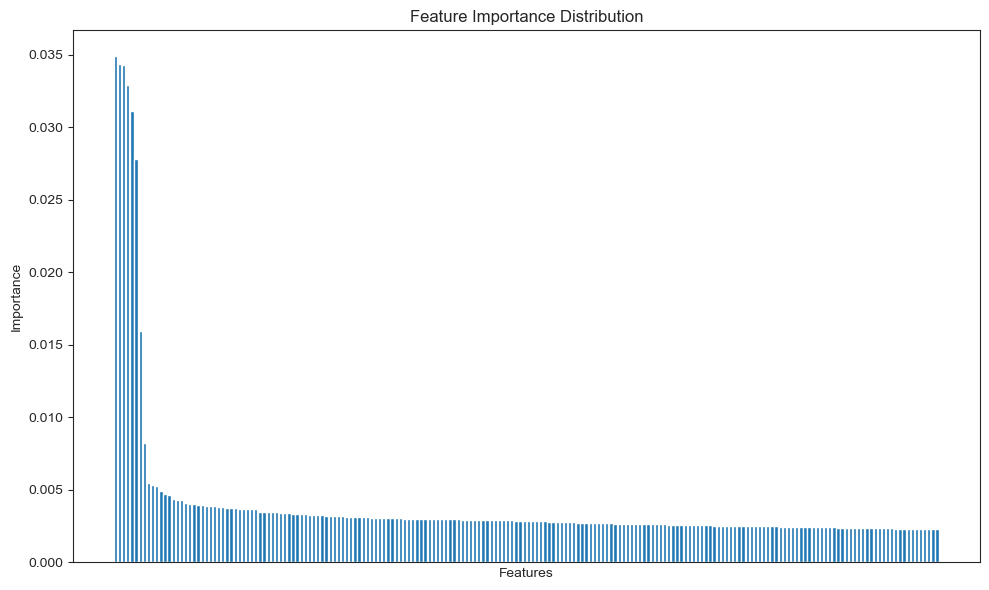

In [73]:
# Calculate the mean feature importances across all folds
mean_importances = np.mean(kf_rf_importances, axis=0)

# Sort the features by their mean importance
sorted_indices = np.argsort(mean_importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = mean_importances[sorted_indices]

# Plot the feature importance distribution
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_features))[:200], sorted_importances[:200])
# plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.xticks([])

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Distribution')
plt.tight_layout()
plt.show()